In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt
alt.renderers.enable('notebook')
%env JOBLIB_TEMP_FOLDER=/tmp

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

from altair.vega import v5
from IPython.display import HTML

env: JOBLIB_TEMP_FOLDER=/tmp


In [234]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [235]:
train_identity = pd.read_csv('data/train_identity.csv')
print("Train identity:{}".format(train_identity.shape))
train_transaction = pd.read_csv('data/train_transaction.csv')
print("Train transaction:{}".format(train_transaction.shape))

Train identity:(144233, 41)
Train transaction:(590540, 394)


In [236]:
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)


# Identity Data
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

- Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

# Transaction Data
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-628660

In [237]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [238]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [239]:
# Join Transaction and Identity dataframes
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [240]:
# Delete identity and transaction dataframes from memory
del train_identity, train_transaction

,0,1
isFraud,0.965009990855827,0.034990009144173


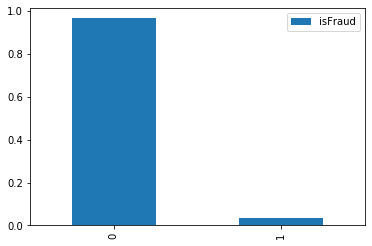

In [241]:
# Ratio of normal transaction vs fraud transactions
fc = train['isFraud'].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

About 3.5% of the transactions are fraud

# Explore Identity Data

In [242]:
train['id_01'].value_counts(dropna=False, normalize=True)

 NaN      0.755760829071697
-5.0      0.139143834456599
 0.0      0.033113760287195
-10.0     0.019062214244590
-20.0     0.018984319436448
-15.0     0.009608155247739
-25.0     0.007828428218241
-45.0     0.003628882040167
-35.0     0.002746638669692
-40.0     0.002345311071223
-100.0    0.001713685779117
-50.0     0.001200596064619
-30.0     0.001154875198970
-95.0     0.000724760388797
-60.0     0.000694279811698
-55.0     0.000541876926203
-80.0     0.000372540386765
-90.0     0.000362380194398
-70.0     0.000164256443255
-65.0     0.000157482981678
-85.0     0.000147322789311
-75.0     0.000140549327734
-18.0     0.000038947404071
-6.0      0.000025400480916
-12.0     0.000025400480916
-11.0     0.000025400480916
-16.0     0.000022013750127
-21.0     0.000020320384733
-7.0      0.000016933653944
-14.0     0.000016933653944
                ...        
-29.0     0.000003386730789
-71.0     0.000003386730789
-99.0     0.000003386730789
-61.0     0.000003386730789
-46.0     0.00000338

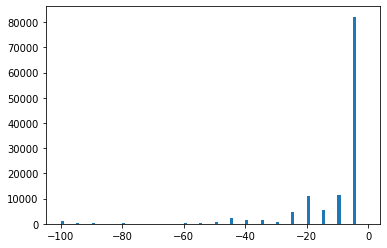

In [243]:
# train['id_01'].value_counts(dropna=False, normalize=True).head()
plt.hist(train['id_01'], range(-100,0))
plt.show()

id_01: 76% is null, 77 unique valuee between -100 and 0 highly skewed to 0.

In [244]:
train['id_02'].value_counts(dropna=False, normalize=True)

NaN         0.761452230162224
1102.0      0.000018627019338
696.0       0.000016933653944
1116.0      0.000015240288549
1120.0      0.000015240288549
1083.0      0.000015240288549
1141.0      0.000015240288549
1117.0      0.000015240288549
1127.0      0.000013546923155
1179.0      0.000011853557761
1119.0      0.000011853557761
1343.0      0.000011853557761
1166.0      0.000011853557761
1109.0      0.000011853557761
1125.0      0.000011853557761
1217.0      0.000011853557761
1089.0      0.000011853557761
1110.0      0.000011853557761
1304.0      0.000011853557761
1138.0      0.000011853557761
552.0       0.000010160192366
1672.0      0.000010160192366
1106.0      0.000010160192366
1201.0      0.000010160192366
2131.0      0.000010160192366
1095.0      0.000010160192366
46347.0     0.000010160192366
542.0       0.000010160192366
1221.0      0.000010160192366
517.0       0.000010160192366
                  ...        
318531.0    0.000001693365394
79633.0     0.000001693365394
79634.0   

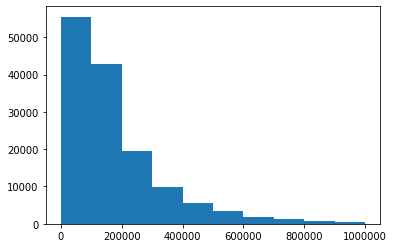

In [245]:
plt.hist(train['id_02'])
plt.show()

In [246]:
train['id_03'].value_counts(dropna=False, normalize=True)

 NaN     0.887689233582822
 0.0     0.108211128797372
 1.0     0.001461374335354
 3.0     0.001131168083449
 2.0     0.000712906831036
 5.0     0.000184576827988
 4.0     0.000169336539438
 6.0     0.000108375385241
-5.0     0.000055881058015
-6.0     0.000052494327226
-4.0     0.000035560673282
-7.0     0.000035560673282
-10.0    0.000028787211705
-8.0     0.000023707115521
-1.0     0.000020320384733
-2.0     0.000020320384733
-3.0     0.000013546923155
-9.0     0.000010160192366
-11.0    0.000010160192366
 7.0     0.000006773461578
 9.0     0.000005080096183
-13.0    0.000005080096183
-12.0    0.000005080096183
 10.0    0.000001693365394
 8.0     0.000001693365394
Name: id_03, dtype: float64

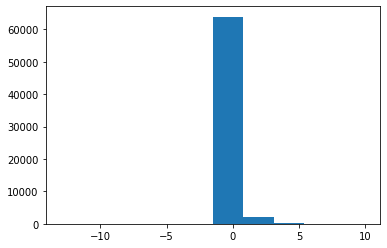

In [247]:
plt.hist(train['id_03'])
plt.show()

id_03: 88% is null, value ranges from -10 to 10, and about 10% is 0

In [248]:
train['id_04'].value_counts(dropna=False, normalize=True)

 NaN     0.887689233582822
 0.0     0.111320147661462
-5.0     0.000223524232059
-6.0     0.000165949808650
-8.0     0.000108375385241
-4.0     0.000086361635114
-1.0     0.000072814711959
-11.0    0.000059267788803
-12.0    0.000057574423409
-10.0    0.000050800961832
-9.0     0.000044027500254
-13.0    0.000040640769465
-7.0     0.000035560673282
-2.0     0.000025400480916
-3.0     0.000016933653944
-28.0    0.000003386730789
Name: id_04, dtype: float64

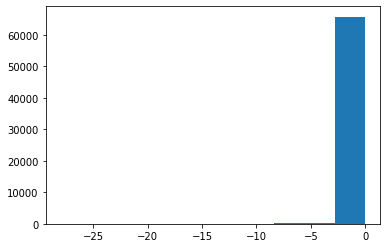

In [249]:
plt.hist(train['id_04'])
plt.show()

id_04: 88% is null, Value ranges from -30 to 0, and 11% is 0

In [250]:
train['id_05'].value_counts(dropna=False, normalize=True)

 NaN     0.768237545297524
 0.0     0.157047786771430
 1.0     0.014043079215633
 2.0     0.008360144952078
 3.0     0.006526230229959
 4.0     0.004980187624886
 6.0     0.003959088292072
 5.0     0.003915060791818
 7.0     0.002497713956718
 8.0     0.002143800589291
 9.0     0.001805127510414
 10.0    0.001706912317540
 11.0    0.001527415585735
 12.0    0.001510481931791
 13.0    0.001297117892099
 14.0    0.001188742506858
-3.0     0.001151488468182
-5.0     0.001139634910421
 15.0    0.001126087987266
-4.0     0.000995698851898
-1.0     0.000992312121109
-2.0     0.000992312121109
 16.0    0.000951671351644
-6.0     0.000894096928235
 17.0    0.000850069427981
-8.0     0.000741694042741
-7.0     0.000741694042741
-9.0     0.000648558946049
 18.0    0.000614691638162
 19.0    0.000601144715007
               ...        
-30.0    0.000023707115521
-26.0    0.000022013750127
 37.0    0.000022013750127
-27.0    0.000018627019338
-22.0    0.000018627019338
 40.0    0.000016933653944
-

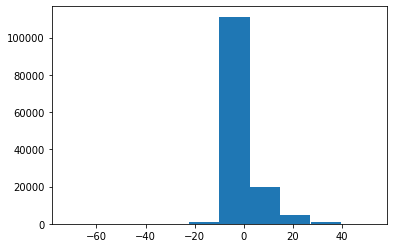

In [251]:
plt.hist(train['id_05'])
plt.show()

id_05: 77% is null, 94 unique values ranging from -70 to 50, 15% is 0

In [252]:
train['id_06'].value_counts(dropna=False, normalize=True)

 NaN      0.768237545297524
 0.0      0.154646594642192
-1.0      0.007936803603482
-5.0      0.006517763402987
-6.0      0.005515291089511
-9.0      0.004460324448810
-100.0    0.004116571273749
-8.0      0.003376570596403
-10.0     0.003325769634572
-11.0     0.003102245402513
-7.0      0.002460459918041
-12.0     0.002304670301758
-4.0      0.002162427608629
-33.0     0.001463067700748
-13.0     0.001461374335354
-28.0     0.001430893758255
-32.0     0.001393639719579
-30.0     0.001376706065635
-26.0     0.001307278084465
-24.0     0.001220916449351
-29.0     0.001180275679886
-31.0     0.001148101737393
-25.0     0.001146408371999
-27.0     0.001143021641210
-22.0     0.001129474718055
-34.0     0.001102380871745
-23.0     0.001063433467674
-3.0      0.000961831544011
-18.0     0.000941511159278
-16.0     0.000878856639686
                ...        
-67.0     0.000032173942493
-74.0     0.000030480577099
-76.0     0.000028787211705
-98.0     0.000028787211705
-84.0     0.00002540

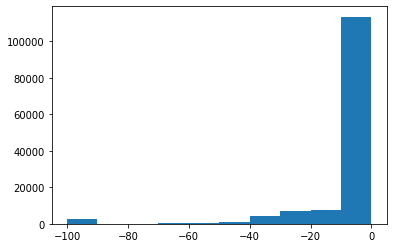

In [253]:
plt.hist(train['id_06'])
plt.show()

id_06: 77% is null, values range from -100 to 0, 15% is 0

In [254]:
train['id_07'].value_counts(dropna=False, normalize=True)

 NaN     0.991270701391946
 0.0     0.000692586446303
 16.0    0.000414874521624
 14.0    0.000386087309920
 12.0    0.000352220002032
 15.0    0.000314965963356
 17.0    0.000304805770989
 4.0     0.000301419040200
 13.0    0.000296338944017
 5.0     0.000260778270735
 10.0    0.000257391539946
 25.0    0.000250618078369
 3.0     0.000238764520608
 22.0    0.000233684424425
 26.0    0.000230297693636
 23.0    0.000228604328242
 24.0    0.000225217597453
 11.0    0.000220137501270
 27.0    0.000220137501270
 8.0     0.000215057405087
 18.0    0.000213364039692
 21.0    0.000206590578115
 20.0    0.000199817116537
 7.0     0.000189656924171
 9.0     0.000186270193382
 2.0     0.000179496731805
 6.0     0.000179496731805
 1.0     0.000164256443255
 19.0    0.000152402885495
 30.0    0.000150709520100
               ...        
-13.0    0.000013546923155
 44.0    0.000011853557761
 41.0    0.000011853557761
-16.0    0.000010160192366
 48.0    0.000008466826972
-11.0    0.000008466826972
-

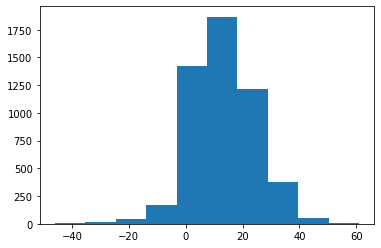

In [255]:
plt.hist(train['id_07'])
plt.show()

id_07: 99% is null, value ranges from -50 to 60 and 0.07% is 0

In [256]:
train['id_08'].value_counts(dropna=False, normalize=True)

 NaN      0.991270701391946
-100.0    0.000846682697192
 0.0      0.000441968367934
-34.0     0.000435194906357
-33.0     0.000353913367426
-32.0     0.000313272597961
-35.0     0.000311579232567
-25.0     0.000213364039692
-31.0     0.000198123751143
-30.0     0.000196430385749
-24.0     0.000194737020354
-51.0     0.000169336539438
-45.0     0.000167643174044
-36.0     0.000167643174044
-27.0     0.000154096250889
-48.0     0.000154096250889
-26.0     0.000150709520100
-19.0     0.000147322789311
-54.0     0.000143936058523
-44.0     0.000138855962340
-23.0     0.000137162596945
-47.0     0.000135469231551
-29.0     0.000135469231551
-37.0     0.000130389135368
-50.0     0.000125309039184
-20.0     0.000123615673790
-52.0     0.000121922308396
-40.0     0.000116842212213
-21.0     0.000111762116029
-9.0      0.000111762116029
                ...        
-63.0     0.000018627019338
-76.0     0.000018627019338
-99.0     0.000015240288549
-61.0     0.000015240288549
-72.0     0.00001524

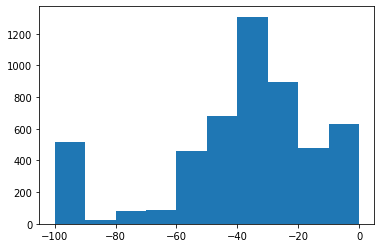

In [257]:
plt.hist(train['id_08'])
plt.show()

id_08: 99% is null, value ranges from -100 to 0

In [258]:
train['id_09'].value_counts(dropna=False, normalize=True)

 NaN     0.873122904460324
 0.0     0.119175669726013
 1.0     0.002736478477326
 3.0     0.001635790970976
 2.0     0.001308971449859
 4.0     0.000457208656484
 5.0     0.000350526636638
 6.0     0.000245537982186
-6.0     0.000111762116029
-5.0     0.000101601923663
-4.0     0.000071121346564
-10.0    0.000066041250381
-7.0     0.000066041250381
-1.0     0.000064347884987
-8.0     0.000062654519592
 7.0     0.000055881058015
-3.0     0.000052494327226
-2.0     0.000045720865648
-9.0     0.000045720865648
 8.0     0.000038947404071
-11.0    0.000030480577099
 9.0     0.000027093846310
 10.0    0.000018627019338
 12.0    0.000010160192366
 11.0    0.000010160192366
-17.0    0.000006773461578
-12.0    0.000006773461578
-13.0    0.000006773461578
-22.0    0.000006773461578
-23.0    0.000006773461578
 13.0    0.000006773461578
 15.0    0.000005080096183
-21.0    0.000005080096183
-31.0    0.000005080096183
 16.0    0.000005080096183
-19.0    0.000003386730789
-15.0    0.000003386730789
-

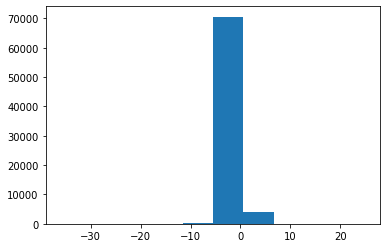

In [259]:
plt.hist(train['id_09'])
plt.show()

id_09: 87% is null, values range from -40 to 30, 11% is 0

In [260]:
train['id_10'].value_counts(dropna=False, normalize=True)

 NaN      0.873122904460324
 0.0      0.123410776577370
-6.0      0.000499542791344
-5.0      0.000418261252413
-1.0      0.000338673078877
-8.0      0.000248924712975
-11.0     0.000215057405087
-9.0      0.000199817116537
-12.0     0.000199817116537
-10.0     0.000194737020354
-7.0      0.000184576827988
-13.0     0.000150709520100
-4.0      0.000147322789311
-16.0     0.000055881058015
-2.0      0.000055881058015
-28.0     0.000042334134860
-3.0      0.000040640769465
-100.0    0.000033867307888
-15.0     0.000030480577099
-14.0     0.000028787211705
-21.0     0.000027093846310
-24.0     0.000025400480916
-22.0     0.000023707115521
-25.0     0.000022013750127
-29.0     0.000022013750127
-19.0     0.000018627019338
-18.0     0.000018627019338
-33.0     0.000016933653944
-31.0     0.000016933653944
-30.0     0.000016933653944
                ...        
-54.0     0.000011853557761
-26.0     0.000011853557761
-47.0     0.000010160192366
-20.0     0.000010160192366
-43.0     0.00000846

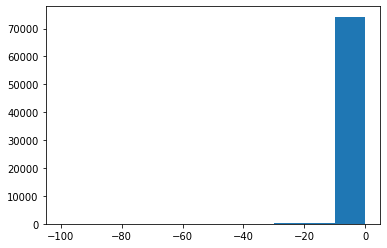

In [261]:
plt.hist(train['id_10'])
plt.show()

id_10: 87% is null, values range from -100 to 0 and 12% is 0

In [262]:
train['id_11'].value_counts(dropna=False, normalize=True)

NaN         0.761272733430420
100.0000    0.225491922647069
95.0625     0.002111626646798
95.1875     0.001359772411691
97.1250     0.000956751447827
96.6875     0.000601144715007
95.6250     0.000508009618315
96.1875     0.000458902021878
94.3125     0.000389474040709
96.7500     0.000387780675314
93.5625     0.000374233752159
96.5000     0.000333592982694
97.5000     0.000282792020862
94.0625     0.000230297693636
94.1875     0.000213364039692
97.6250     0.000201510481932
96.4375     0.000171029904833
96.2500     0.000159176347072
95.7500     0.000155789616283
95.6875     0.000149016154706
93.3125     0.000147322789311
97.0625     0.000142242693128
94.1250     0.000140549327734
97.1875     0.000128695769973
97.5625     0.000096521827480
94.3750     0.000094828462086
90.1875     0.000093135096691
96.5625     0.000093135096691
97.0000     0.000091441731297
98.3125     0.000091441731297
                  ...        
92.0000     0.000008466826972
97.3750     0.000008466826972
99.2500   

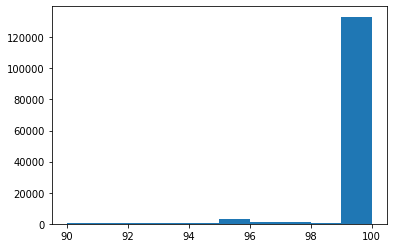

In [263]:
plt.hist(train['id_11'])
plt.show()

id_11: 76% is null, values range from 90 to 100 and 22% is 100

In [264]:
# train['id_01'].value_counts().head()
train['id_12'].value_counts(dropna=False, normalize=True)

NaN         0.755760829071697
NotFound    0.208326277644190
Found       0.035912893284113
Name: id_12, dtype: float64

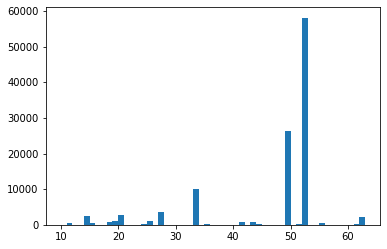

In [265]:
plt.hist(train['id_13'], range(10, 64))
plt.show()

id_13 has values between 10 and 64
- NaN      0.784401
- 52.0    0.098383
- 49.0    0.044646
- 64.0    0.024434
- 33.0    0.017015

In [266]:
train['id_14'].value_counts(dropna=False)

 NaN      510496
-300.0     44121
-360.0     16661
-480.0     12891
-420.0      4542
-600.0       498
 60.0        369
 0.0         192
-240.0       159
-180.0       126
-540.0       111
 480.0        80
 540.0        64
 600.0        62
 120.0        41
 180.0        37
 420.0        19
 330.0        17
 270.0        15
 240.0        13
 300.0        12
 720.0         9
-660.0         2
-210.0         1
 360.0         1
-120.0         1
Name: id_14, dtype: int64

id_14 min: -660.0, max: 720.0


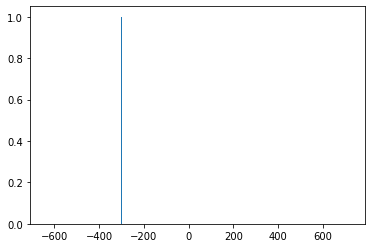

In [267]:
print('id_14 min: {}, max: {}'.format(train['id_14'].min(), train['id_14'].max()))
plt.hist(train['id_14'].head(10), range(-640,720))
plt.show()

id_14 min: -660.0, max: 720.0
- NaN       0.864456
- -300.0    0.074713
- -360.0    0.028213
- -480.0    0.021829
- -420.0    0.007691

In [268]:
train['id_15'].value_counts(dropna=False, normalize=True)

NaN        0.761260879872659
Found      0.114688251430894
New        0.104331628678836
Unknown    0.019719240017611
Name: id_15, dtype: float64

In [269]:
train['id_16'].value_counts(dropna=False, normalize=True)

NaN         0.780980119890270
Found       0.112310766417177
NotFound    0.106709113692553
Name: id_16, dtype: float64

In [270]:
train['id_17'].value_counts(dropna=False, normalize=True)

NaN      0.763997358349985
166.0    0.133151014325871
225.0    0.096467639787313
102.0    0.001166728756731
159.0    0.000596064618823
100.0    0.000568970772513
121.0    0.000472448945033
148.0    0.000387780675314
150.0    0.000213364039692
191.0    0.000208283943509
142.0    0.000206590578115
192.0    0.000182883462594
144.0    0.000157482981678
149.0    0.000142242693128
218.0    0.000130389135368
106.0    0.000108375385241
183.0    0.000104988654452
146.0    0.000103295289057
133.0    0.000082974904325
135.0    0.000082974904325
195.0    0.000082974904325
137.0    0.000077894808142
210.0    0.000064347884987
119.0    0.000057574423409
143.0    0.000050800961832
205.0    0.000047414231043
168.0    0.000045720865648
171.0    0.000042334134860
147.0    0.000040640769465
212.0    0.000038947404071
               ...        
180.0    0.000008466826972
117.0    0.000006773461578
178.0    0.000006773461578
124.0    0.000006773461578
213.0    0.000005080096183
186.0    0.000005080096183
1

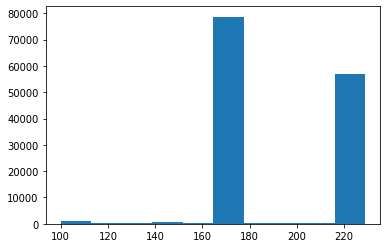

In [271]:
plt.hist(train['id_17'])
plt.show()

In [272]:
train['id_18'].value_counts(dropna=False, normalize=True)

NaN     0.923607206963118
15.0    0.043162190537474
13.0    0.022757137535137
12.0    0.007884309276256
18.0    0.001100687506350
20.0    0.000574050868696
17.0    0.000394554136892
26.0    0.000150709520100
21.0    0.000132082500762
24.0    0.000088055000508
11.0    0.000060961154198
27.0    0.000054187692620
29.0    0.000015240288549
23.0    0.000006773461578
14.0    0.000005080096183
16.0    0.000001693365394
25.0    0.000001693365394
28.0    0.000001693365394
10.0    0.000001693365394
Name: id_18, dtype: float64

In [273]:
train['id_19'].value_counts(dropna=False, normalize=True)

NaN      0.764083719985098
266.0    0.033611609713144
410.0    0.019165509533647
427.0    0.014915162393741
529.0    0.013753513733193
312.0    0.010544586310834
100.0    0.008910488705253
542.0    0.008663257357673
215.0    0.008006231584651
153.0    0.007423713888983
417.0    0.006917397636062
352.0    0.006631218884411
176.0    0.006510989941410
290.0    0.006126595996884
193.0    0.005239272530227
633.0    0.004575473295628
254.0    0.004565313103261
548.0    0.004506045314458
621.0    0.003645815694110
390.0    0.003214007518542
317.0    0.003205540691570
321.0    0.002919361939919
122.0    0.002792359535341
216.0    0.002700917804044
271.0    0.002490940495140
567.0    0.002382565109899
492.0    0.002365631455956
341.0    0.002143800589291
384.0    0.001891489145528
484.0    0.001642564432553
               ...        
174.0    0.000001693365394
467.0    0.000001693365394
319.0    0.000001693365394
301.0    0.000001693365394
485.0    0.000001693365394
524.0    0.000001693365394
5

In [274]:
train['id_20'].value_counts(dropna=False, normalize=True)

NaN      0.764180241812578
507.0    0.037780675314119
222.0    0.018737088088868
325.0    0.013772140752532
533.0    0.011194838622278
214.0    0.009591221593796
549.0    0.009555660920513
600.0    0.009420191688963
563.0    0.007977444372947
333.0    0.006250211670674
595.0    0.005889524841670
161.0    0.005374741761777
500.0    0.004748196565855
401.0    0.004362109255935
489.0    0.004318081755681
597.0    0.004287601178582
305.0    0.004101330985200
256.0    0.003828699156704
368.0    0.003759271175534
127.0    0.003637348867139
535.0    0.003589934636096
391.0    0.003071764825414
277.0    0.002655196938395
561.0    0.002592542418803
177.0    0.002394418667660
280.0    0.002387645206083
315.0    0.002220002032038
612.0    0.002177667897179
566.0    0.002037118569445
266.0    0.002001557896163
               ...        
273.0    0.000001693365394
265.0    0.000001693365394
262.0    0.000001693365394
259.0    0.000001693365394
246.0    0.000001693365394
255.0    0.000001693365394
2

In [275]:
train['id_21'].value_counts(dropna=False, normalize=True)

NaN      0.991263927930369
252.0    0.004304534832526
228.0    0.000404714329258
255.0    0.000184576827988
596.0    0.000174416635622
576.0    0.000171029904833
849.0    0.000149016154706
277.0    0.000145629423917
755.0    0.000110068750635
848.0    0.000098215192874
668.0    0.000089748365902
770.0    0.000082974904325
249.0    0.000067734615775
537.0    0.000064347884987
256.0    0.000050800961832
286.0    0.000047414231043
440.0    0.000047414231043
306.0    0.000045720865648
819.0    0.000045720865648
728.0    0.000044027500254
189.0    0.000042334134860
500.0    0.000040640769465
409.0    0.000038947404071
734.0    0.000035560673282
262.0    0.000035560673282
762.0    0.000032173942493
453.0    0.000032173942493
854.0    0.000030480577099
232.0    0.000030480577099
528.0    0.000027093846310
               ...        
335.0    0.000001693365394
792.0    0.000001693365394
790.0    0.000001693365394
197.0    0.000001693365394
336.0    0.000001693365394
132.0    0.000001693365394
3

In [276]:
train['id_22'].value_counts(dropna=False, normalize=True)

NaN     0.991246994276425
14.0    0.008019778507806
41.0    0.000543570291598
33.0    0.000064347884987
21.0    0.000011853557761
17.0    0.000011853557761
39.0    0.000010160192366
35.0    0.000008466826972
36.0    0.000008466826972
22.0    0.000008466826972
12.0    0.000008466826972
31.0    0.000008466826972
24.0    0.000006773461578
20.0    0.000006773461578
26.0    0.000006773461578
42.0    0.000005080096183
28.0    0.000005080096183
19.0    0.000003386730789
38.0    0.000003386730789
18.0    0.000001693365394
44.0    0.000001693365394
43.0    0.000001693365394
40.0    0.000001693365394
23.0    0.000001693365394
37.0    0.000001693365394
10.0    0.000001693365394
Name: id_22, dtype: float64

In [277]:
train['id_23'].value_counts(dropna=False, normalize=True)

NaN                     0.991246994276425
IP_PROXY:TRANSPARENT    0.005908151861009
IP_PROXY:ANONYMOUS      0.001813594337386
IP_PROXY:HIDDEN         0.001031259525180
Name: id_23, dtype: float64

In [278]:
train['id_24'].value_counts(dropna=False, normalize=True)

NaN     0.991961594472855
11.0    0.004770210315982
15.0    0.002699224438649
16.0    0.000372540386765
18.0    0.000062654519592
21.0    0.000055881058015
24.0    0.000020320384733
17.0    0.000015240288549
26.0    0.000013546923155
25.0    0.000011853557761
19.0    0.000008466826972
12.0    0.000006773461578
23.0    0.000001693365394
Name: id_24, dtype: float64

In [279]:
train['id_25'].value_counts(dropna=False, normalize=True)

NaN      0.991309648796017
321.0    0.004223253293596
205.0    0.000509702983710
426.0    0.000399634233075
501.0    0.000174416635622
371.0    0.000140549327734
524.0    0.000132082500762
442.0    0.000130389135368
509.0    0.000110068750635
123.0    0.000089748365902
126.0    0.000086361635114
505.0    0.000082974904325
356.0    0.000047414231043
247.0    0.000047414231043
486.0    0.000045720865648
359.0    0.000045720865648
463.0    0.000045720865648
143.0    0.000044027500254
512.0    0.000042334134860
479.0    0.000040640769465
511.0    0.000040640769465
385.0    0.000035560673282
460.0    0.000033867307888
239.0    0.000032173942493
170.0    0.000032173942493
258.0    0.000030480577099
443.0    0.000030480577099
270.0    0.000030480577099
499.0    0.000030480577099
236.0    0.000028787211705
               ...        
341.0    0.000001693365394
187.0    0.000001693365394
263.0    0.000001693365394
189.0    0.000001693365394
195.0    0.000001693365394
197.0    0.000001693365394
2

In [280]:
train['id_26'].value_counts(dropna=False, normalize=True)

NaN      0.991257154468791
161.0    0.001395333084973
184.0    0.000985538659532
142.0    0.000894096928235
102.0    0.000763707792868
100.0    0.000733227215769
119.0    0.000635012022894
169.0    0.000618078368950
147.0    0.000394554136892
215.0    0.000240457886003
121.0    0.000193043654960
182.0    0.000186270193382
146.0    0.000171029904833
194.0    0.000155789616283
190.0    0.000101601923663
216.0    0.000094828462086
150.0    0.000069427981170
149.0    0.000062654519592
137.0    0.000062654519592
117.0    0.000060961154198
133.0    0.000057574423409
199.0    0.000055881058015
138.0    0.000049107596437
162.0    0.000042334134860
143.0    0.000042334134860
168.0    0.000038947404071
106.0    0.000035560673282
177.0    0.000032173942493
107.0    0.000028787211705
159.0    0.000028787211705
               ...        
201.0    0.000003386730789
123.0    0.000003386730789
124.0    0.000003386730789
125.0    0.000003386730789
209.0    0.000003386730789
108.0    0.000003386730789
1

In [281]:
train['id_27'].value_counts(dropna=False, normalize=True)

NaN         0.991246994276425
Found       0.008729298608054
NotFound    0.000023707115521
Name: id_27, dtype: float64

In [282]:
train['id_28'].value_counts(dropna=False, normalize=True)

NaN      0.761272733430420
Found    0.129088630744742
New      0.109638635824838
Name: id_28, dtype: float64

In [283]:
train['id_29'].value_counts(dropna=False, normalize=True)

NaN         0.761272733430420
Found       0.126877095539676
NotFound    0.111850171029905
Name: id_29, dtype: float64

In [284]:
train['id_30'].value_counts(dropna=False, normalize=True)

NaN                 0.868654113184543
Windows 10          0.035823144918210
Windows 7           0.022200020320385
iOS 11.2.1          0.006302705997900
iOS 11.1.2          0.006263758593829
Android 7.0         0.004861652047279
Mac OS X 10_12_6    0.004333322044231
Mac OS X 10_11_6    0.003976021946016
iOS 11.3.0          0.003413824635080
Windows 8.1         0.003241101364853
Mac OS X 10_10_5    0.002795746266129
iOS 11.2.6          0.002788972804552
iOS 10.3.3          0.002638263284452
Mac OS X 10_13_2    0.002406272225421
Mac OS X 10_13_1    0.002050665492600
iOS 11.2.5          0.002032038473262
Linux               0.001923663088021
Android             0.001827141260541
iOS 11.2.2          0.001527415585735
Mac OS X 10_13_3    0.001456294239171
iOS 11.2.0          0.001442747316016
Mac OS X 10_13_4    0.001285264334338
iOS 11.1.1          0.001185355776069
iOS 11.0.3          0.001115927794900
Android 7.1.1       0.001066820198462
Mac OS X 10_9_5     0.000965218274799
Android 6.0.

In [ ]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_30 OS
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)

train['id_30'].value_counts()

In [285]:
train['id_31'].value_counts(dropna=False, normalize=True)

NaN                           0.762451315744911
chrome 63.0                   0.037254038676466
mobile safari 11.0            0.022730043688827
mobile safari generic         0.019429674535171
ie 11.0 for desktop           0.015291089511295
safari generic                0.013877129406983
chrome 62.0                   0.012161750262472
chrome 65.0                   0.011635113624818
chrome 64.0                   0.011364175161716
chrome 63.0 for android       0.009831679479798
chrome generic                0.008090899854371
chrome 66.0                   0.007220510041657
edge 16.0                     0.007091814271684
chrome 64.0 for android       0.005881058014698
chrome 65.0 for android       0.005649066955668
firefox 57.0                  0.005613506282386
mobile safari 10.0            0.004705862430995
chrome 66.0 for android       0.003977715311410
chrome 62.0 for android       0.003550987232025
edge 15.0                     0.002709384631016
chrome generic for android    0.00196091

In [286]:
train['id_32'].value_counts(dropna=False, normalize=True)

NaN     0.868618552511261
24.0    0.089868594845396
32.0    0.041365529854032
16.0    0.000137162596945
0.0     0.000010160192366
Name: id_32, dtype: float64

In [287]:
train['id_33'].value_counts(dropna=False, normalize=True)

NaN          0.875894943610932
1920x1080    0.028573847664849
1366x768     0.014571409218681
1334x750     0.010917126697599
2208x1242    0.008297490432486
1440x900     0.007423713888983
1600x900     0.005943712534291
2048x1536    0.005896298303248
1280x800     0.003639042232533
2560x1600    0.003544213770447
2560x1440    0.003158126460528
2880x1800    0.002973549632540
1280x1024    0.002951535882413
1680x1050    0.002924442036103
1136x640     0.002899041555187
2436x1125    0.002512954245267
1280x720     0.002231855589799
1920x1200    0.001788193856470
2001x1125    0.001727232702272
1024x768     0.001395333084973
2220x1080    0.000921190774545
5120x2880    0.000672266061571
3360x2100    0.000643478849866
2732x2048    0.000599451349612
1366x767     0.000567277407119
3840x2160    0.000445355098723
855x480      0.000423341348596
2736x1824    0.000408101060047
1360x768     0.000379313848342
4096x2304    0.000352220002032
                   ...        
1439x809     0.000001693365394
1920x101

In [288]:
train['id_34'].value_counts(dropna=False, normalize=True)

NaN                0.868247705489891
match_status:2     0.101620550682426
match_status:1     0.029423917092830
match_status:0     0.000702746638670
match_status:-1    0.000005080096183
Name: id_34, dtype: float64

In [289]:
train['id_35'].value_counts(dropna=False, normalize=True)

NaN    0.761260879872659
T      0.131767534798659
F      0.106971585328682
Name: id_35, dtype: float64

In [290]:
train['id_36'].value_counts(dropna=False, normalize=True)

NaN    0.761260879872659
F      0.227022724963593
T      0.011716395163748
Name: id_36, dtype: float64

In [291]:
train['id_37'].value_counts(dropna=False, normalize=True)

NaN    0.761260879872659
T      0.187035594540590
F      0.051703525586751
Name: id_37, dtype: float64

In [292]:
train['id_38'].value_counts(dropna=False, normalize=True)

NaN    0.761260879872659
F      0.125176956683713
T      0.113562163443628
Name: id_38, dtype: float64

In [293]:
train['DeviceType'].value_counts(dropna=False, normalize=True)

NaN        0.761557218816676
desktop    0.144215463812782
mobile     0.094227317370542
Name: DeviceType, dtype: float64

In [294]:
train['DeviceInfo'].value_counts(dropna=False, normalize=True)

NaN                               0.799055102109933
Windows                           0.080810783350831
iOS Device                        0.033498154231720
MacOS                             0.021290683103600
Trident/7.0                       0.012598638534223
rv:11.0                           0.003219087614726
rv:57.0                           0.001629017509398
SM-J700M Build/MMB29K             0.000929657601517
SM-G610M Build/MMB29K             0.000780641446811
SM-G531H Build/LMY48B             0.000694279811698
rv:59.0                           0.000612998272767
SM-G935F Build/NRD90M             0.000565584041725
SM-G955U Build/NRD90M             0.000555423849358
SM-G532M Build/MMB29T             0.000535103464626
ALE-L23 Build/HuaweiALE-L23       0.000528330003048
SM-G950U Build/NRD90M             0.000491075964372
SM-G930V Build/NRD90M             0.000463982118061
rv:58.0                           0.000455515291090
rv:52.0                           0.000433501540963
SAMSUNG     

# Explore Transaction Data

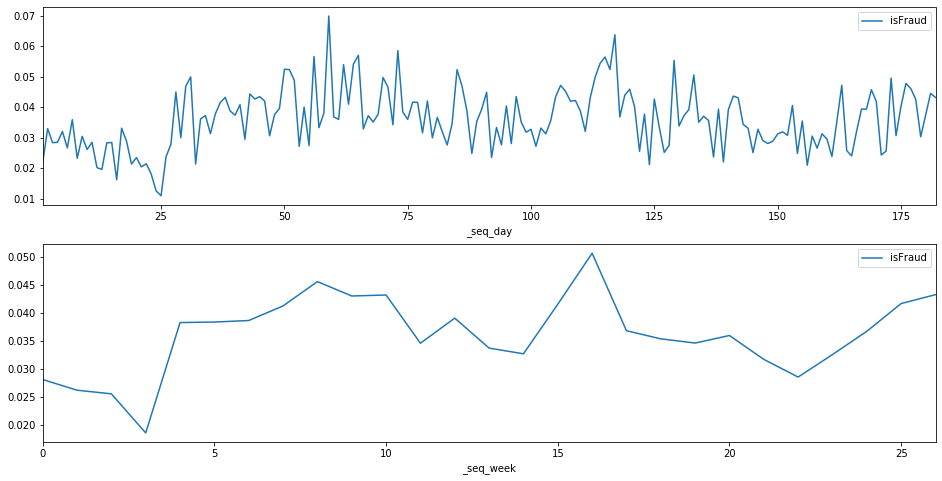

In [295]:
# https://www.kaggle.com/plasticgrammer/ieee-cis-fraud-detection-eda
fig,ax = plt.subplots(2, 1, figsize=(16,8))

train['_seq_day'] = train['TransactionDT'] // (24*60*60)
train['_seq_week'] = train['_seq_day'] // 7
train.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax=ax[0])
train.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax=ax[1])

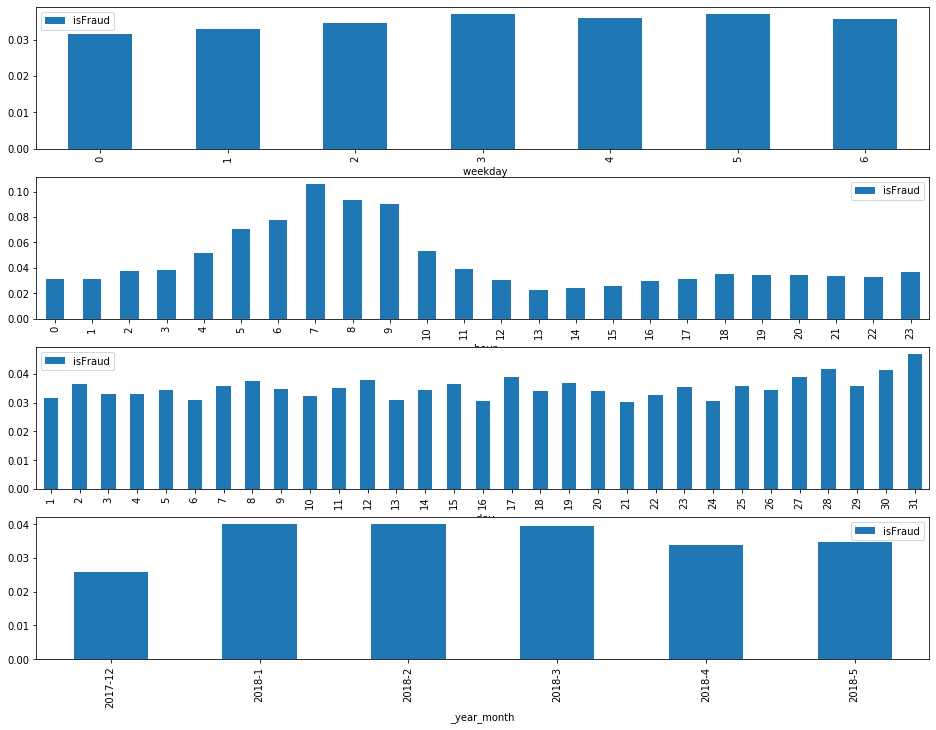

In [296]:
# http://localhost:8888/notebooks/IEEE-CIS%20Fraud%20Detection%20_%20EDA.ipynb
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['_ymd'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str) + '-' + train['Date'].dt.day.astype(str)
train['_year_month'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str)
train['_weekday'] = train['Date'].dt.dayofweek
train['_hour'] = train['Date'].dt.hour
train['_day'] = train['Date'].dt.day

fig,ax = plt.subplots(4, 1, figsize=(16,12))

train.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train.groupby('_year_month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

In [297]:
train['card1'].value_counts(dropna=False, normalize=True)

7919     0.025285332068954
9500     0.023981440715278
15885    0.017544958851221
17188    0.017516171639516
15066    0.013453788058387
12695    0.012007654011583
12544    0.011469163816168
6019     0.011465777085379
2803     0.010398956886917
7585     0.009032411013649
10616    0.008758085819758
12839    0.008685271107800
3154     0.007813187929691
2616     0.007467741389237
18132    0.007127374944966
9633     0.007041013309852
15497    0.006734514173468
16132    0.006653232634538
2884     0.006558404172452
16075    0.006346733498154
11207    0.006253598401463
10112    0.006028380804010
7508     0.005909845226403
10057    0.005361194838622
12501    0.005337487723101
7826     0.005090256375521
16659    0.005059775798422
12577    0.004895519355166
5812     0.004771903681376
7664     0.004727876181122
               ...        
15229    0.000001693365394
7772     0.000001693365394
12456    0.000001693365394
16550    0.000001693365394
5218     0.000001693365394
3958     0.000001693365394
1

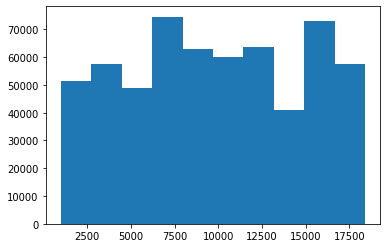

In [298]:
plt.hist(train['card1'])
plt.show()

In [299]:
train['card2'].value_counts(dropna=False, normalize=True)

321.0    0.082864835574220
111.0    0.076524875537644
555.0    0.071112879737190
490.0    0.064593422968808
583.0    0.036920445693772
170.0    0.030842957293325
194.0    0.028682223050090
545.0    0.027694991025163
360.0    0.025722220340705
514.0    0.024623226199749
174.0    0.019151962610492
512.0    0.017147017983540
NaN      0.015126833068039
408.0    0.013567243539811
361.0    0.013253970941850
100.0    0.012818776035493
225.0    0.012607105361195
215.0    0.012329393436516
399.0    0.012158363531683
553.0    0.010998408236529
481.0    0.010729163138822
268.0    0.010564906695567
567.0    0.010392183425340
476.0    0.009858773326108
375.0    0.009267788803468
543.0    0.009230534764792
327.0    0.008636163511362
500.0    0.008543028414671
298.0    0.007376299657940
206.0    0.007125681579571
               ...        
117.0    0.000104988654452
137.0    0.000104988654452
531.0    0.000104988654452
526.0    0.000104988654452
358.0    0.000103295289057
163.0    0.000101601923663
5

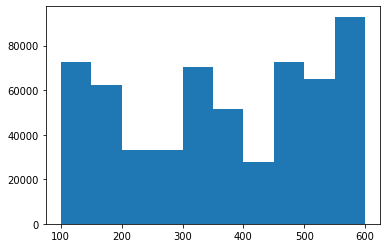

In [300]:
plt.hist(train['card2'])
plt.show()

In [301]:
train['card3'].value_counts(dropna=False, normalize=True)

150.0    0.882729366342669
185.0    0.095414366512006
106.0    0.002660277034579
NaN      0.002650116842212
146.0    0.002120093473770
144.0    0.002120093473770
117.0    0.001629017509398
143.0    0.001522335489552
119.0    0.001270024045789
102.0    0.000778948081417
147.0    0.000660412503810
162.0    0.000574050868696
203.0    0.000428421444779
213.0    0.000374233752159
100.0    0.000342059809666
200.0    0.000311579232567
188.0    0.000296338944017
131.0    0.000291258847834
134.0    0.000281098655468
149.0    0.000215057405087
135.0    0.000203203847326
229.0    0.000199817116537
210.0    0.000176110001016
195.0    0.000171029904833
121.0    0.000167643174044
159.0    0.000138855962340
197.0    0.000137162596945
137.0    0.000120228943001
138.0    0.000118535577607
214.0    0.000111762116029
               ...        
155.0    0.000005080096183
181.0    0.000005080096183
202.0    0.000005080096183
205.0    0.000005080096183
174.0    0.000005080096183
207.0    0.000005080096183
2

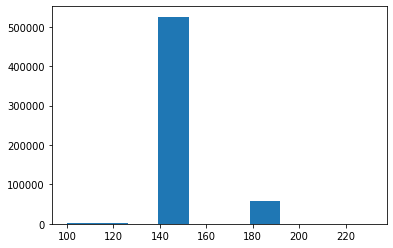

In [302]:
plt.hist(train['card3'])
plt.show()

In [303]:
train['card4'].value_counts(dropna=False, normalize=True)

visa                0.651551122701256
mastercard          0.320413519829309
american express    0.014102347004437
discover            0.011262573238053
NaN                 0.002670437226945
Name: card4, dtype: float64

In [304]:
train['card5'].value_counts(dropna=False, normalize=True)

226.0    0.502160734243235
224.0    0.138031293392488
166.0    0.096758898635147
102.0    0.049285399803570
117.0    0.043927591695736
138.0    0.033421952788973
195.0    0.028694076607850
137.0    0.019846242422190
126.0    0.017438276831375
219.0    0.016804958173875
202.0    0.012027974396315
162.0    0.007660785044197
NaN      0.007212043214685
229.0    0.003468012327700
197.0    0.002626409726691
150.0    0.002265722897687
100.0    0.001656111355708
223.0    0.001584990009144
118.0    0.001273410776577
190.0    0.001259863853422
146.0    0.001136248179632
198.0    0.001134554814238
236.0    0.001095607410167
185.0    0.000802655196938
203.0    0.000724760388797
147.0    0.000706133369458
141.0    0.000577437599485
129.0    0.000550343753175
142.0    0.000469062214245
194.0    0.000438581637146
               ...        
172.0    0.000005080096183
216.0    0.000005080096183
231.0    0.000003386730789
140.0    0.000003386730789
113.0    0.000003386730789
191.0    0.000003386730789
1

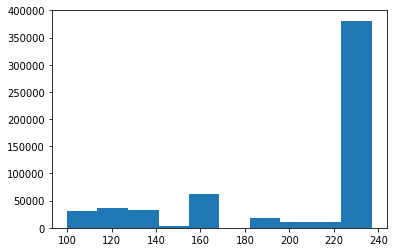

In [305]:
plt.hist(train['card5'])
plt.show()

In [306]:
train['card6'].value_counts(dropna=False, normalize=True)

debit              0.744975784874860
credit             0.252287736647814
NaN                0.002660277034579
debit or credit    0.000050800961832
charge card        0.000025400480916
Name: card6, dtype: float64

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.

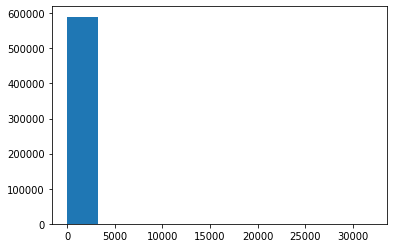

In [307]:
plt.hist(train['TransactionAmt'])
plt.show()

In [308]:
train['ProductCD'].value_counts(dropna=False, normalize=True)

W    0.744521962949165
C    0.116027703457852
R    0.063838182002913
H    0.055921698784164
S    0.019690452805906
Name: ProductCD, dtype: float64

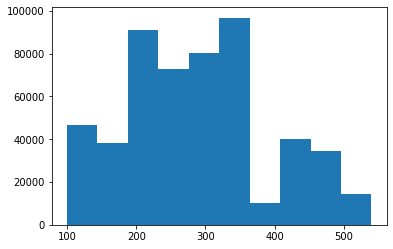

In [309]:
plt.hist(train['addr1'])
plt.show()

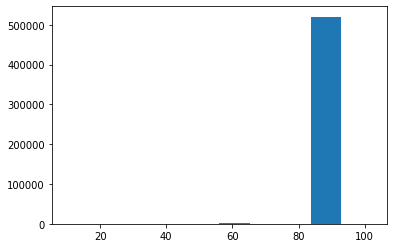

In [310]:
plt.hist(train['addr2'])
plt.show()

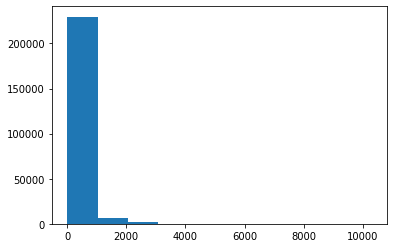

In [311]:
plt.hist(train['dist1'])
plt.show()

In [312]:
train['P_emaildomain'].value_counts(dropna=False, normalize=True)

gmail.com           0.386688454634741
yahoo.com           0.170918142716835
NaN                 0.159948521692011
hotmail.com         0.076624784095912
anonymous.com       0.062651132861449
aol.com             0.047903613641752
comcast.net         0.013357266230907
icloud.com          0.010612320926610
outlook.com         0.008629390049785
msn.com             0.006929251193823
att.net             0.006829342635554
live.com            0.005149524164324
sbcglobal.net       0.005029295221323
verizon.net         0.004580553391811
ymail.com           0.004057303484946
bellsouth.net       0.003232634537881
yahoo.com.mx        0.002612862803536
me.com              0.002577302130254
cox.net             0.002358857994378
optonline.net       0.001711992413723
charter.net         0.001381786161818
live.com.mx         0.001268330680394
rocketmail.com      0.001124394621872
mail.com            0.000946591255461
earthlink.net       0.000870389812714
gmail               0.000839909235615
outlook.es  

In [313]:
train['R_emaildomain'].value_counts(dropna=False, normalize=True)

NaN                 0.767516171639516
gmail.com           0.096770752192908
hotmail.com         0.046582788634131
anonymous.com       0.034763098181326
yahoo.com           0.020052833000305
aol.com             0.006267145324618
outlook.com         0.004245267043723
comcast.net         0.003068378094625
yahoo.com.mx        0.002553595014732
icloud.com          0.002367324821350
msn.com             0.001442747316016
live.com            0.001290344430521
live.com.mx         0.001276797507366
verizon.net         0.001049886544519
me.com              0.000941511159278
sbcglobal.net       0.000934737697700
cox.net             0.000777254716023
outlook.es          0.000733227215769
att.net             0.000728147119585
bellsouth.net       0.000714600196430
hotmail.fr          0.000496156060555
hotmail.es          0.000494462695160
web.de              0.000401327598469
mac.com             0.000369153655976
ymail.com           0.000350526636638
prodigy.net.mx      0.000350526636638
optonline.ne

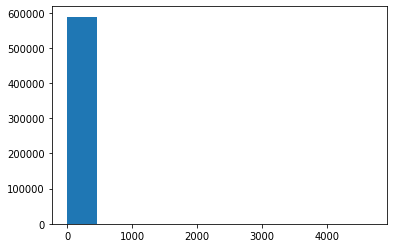

In [314]:
plt.hist(train['C1'])
plt.show()

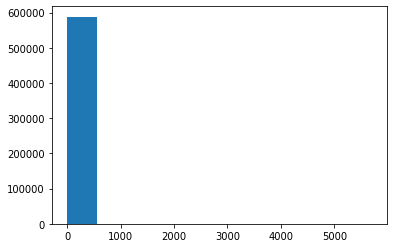

In [315]:
plt.hist(train['C2'])
plt.show()

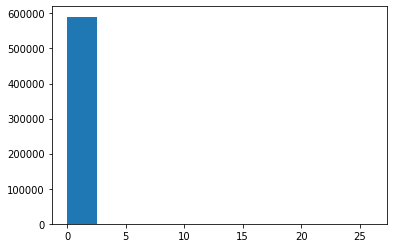

In [316]:
plt.hist(train['C3'])
plt.show()

In [317]:
train['C4'].value_counts(dropna=False, normalize=True)

0.0       0.765203034510787
1.0       0.189347038303925
2.0       0.022003589934636
3.0       0.008380465336810
4.0       0.003220780980120
5.0       0.001441053950621
6.0       0.001010939140448
7.0       0.000629931926711
9.0       0.000462288752667
10.0      0.000394554136892
8.0       0.000382700579131
12.0      0.000296338944017
11.0      0.000282792020862
16.0      0.000196430385749
15.0      0.000196430385749
17.0      0.000191350289565
13.0      0.000184576827988
14.0      0.000154096250889
20.0      0.000137162596945
18.0      0.000120228943001
52.0      0.000106682019846
21.0      0.000101601923663
19.0      0.000098215192874
30.0      0.000082974904325
83.0      0.000072814711959
24.0      0.000069427981170
70.0      0.000067734615775
51.0      0.000066041250381
91.0      0.000059267788803
39.0      0.000059267788803
                ...        
1010.0    0.000001693365394
1792.0    0.000001693365394
252.0     0.000001693365394
1007.0    0.000001693365394
2016.0    0.00000169

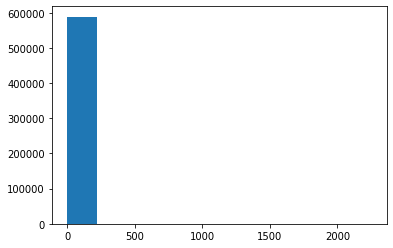

In [318]:
plt.hist(train['C4'])
plt.show()

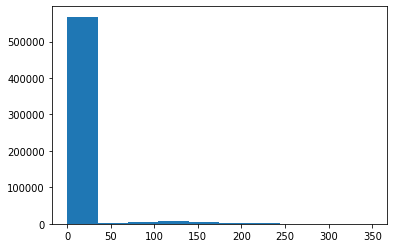

In [319]:
plt.hist(train['C5'])
plt.show()

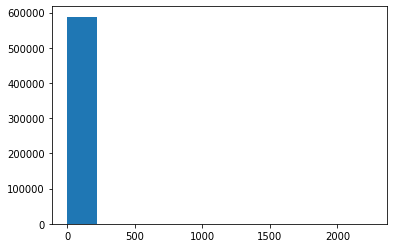

In [320]:
plt.hist(train['C6'])
plt.show()

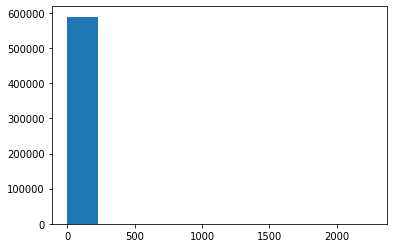

In [321]:
plt.hist(train['C7'])
plt.show()

In [322]:
train['C7'].value_counts(dropna=False, normalize=True)

0.0       0.885870559149253
1.0       0.087997426084601
2.0       0.012385274494530
3.0       0.003442611846784
4.0       0.001877942222373
5.0       0.000814508754699
6.0       0.000692586446303
7.0       0.000452128560301
9.0       0.000394554136892
10.0      0.000296338944017
8.0       0.000292952213229
11.0      0.000199817116537
16.0      0.000182883462594
17.0      0.000171029904833
15.0      0.000143936058523
13.0      0.000140549327734
14.0      0.000118535577607
20.0      0.000115148846818
52.0      0.000106682019846
18.0      0.000096521827480
12.0      0.000094828462086
19.0      0.000079588173536
30.0      0.000076201442747
83.0      0.000071121346564
92.0      0.000067734615775
70.0      0.000067734615775
51.0      0.000062654519592
35.0      0.000059267788803
21.0      0.000057574423409
24.0      0.000055881058015
                ...        
1171.0    0.000001693365394
520.0     0.000001693365394
292.0     0.000001693365394
1209.0    0.000001693365394
476.0     0.00000169

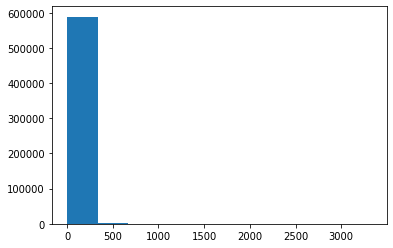

In [323]:
plt.hist(train['C8'])
plt.show()

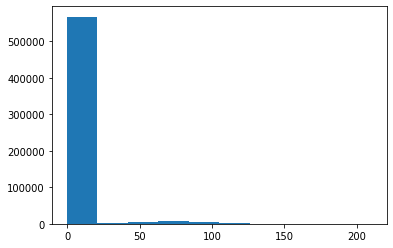

In [324]:
plt.hist(train['C9'])
plt.show()

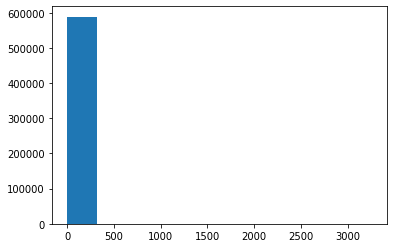

In [325]:
plt.hist(train['C10'])
plt.show()

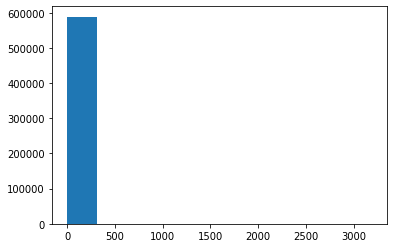

In [326]:
plt.hist(train['C11'])
plt.show()

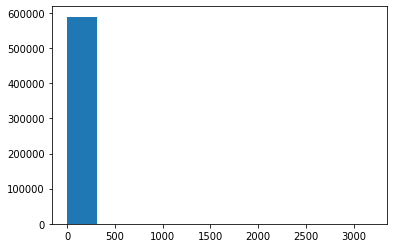

In [327]:
plt.hist(train['C12'])
plt.show()

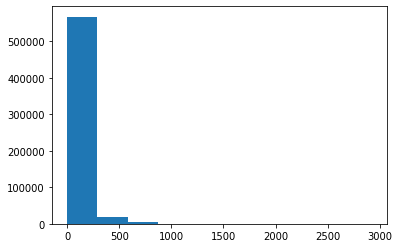

In [328]:
plt.hist(train['C13'])
plt.show()

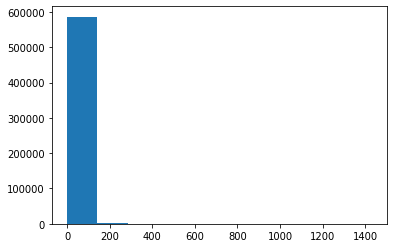

In [329]:
plt.hist(train['C14'])
plt.show()

In [330]:
train['D1'].value_counts(dropna=False, normalize=True)

0.0      0.474362447929014
1.0      0.014620516815118
2.0      0.008414332644698
3.0      0.006695566769398
4.0      0.006045314457954
7.0      0.005850577437599
6.0      0.005357808107834
5.0      0.005208791953128
14.0     0.005044535509872
8.0      0.004465404544993
28.0     0.004460324448810
9.0      0.004042063196397
13.0     0.004011582619298
42.0     0.003884580214719
15.0     0.003762657906323
11.0     0.003588241270701
10.0     0.003581467809124
12.0     0.003506959731771
29.0     0.003452772039151
21.0     0.003425678192840
35.0     0.003325769634572
16.0     0.003137806075795
30.0     0.003068378094625
27.0     0.003032817421343
22.0     0.002904121651370
20.0     0.002893961459004
18.0     0.002890574728215
17.0     0.002804213093101
43.0     0.002748332035087
26.0     0.002721238188776
               ...        
624.0    0.000243844616791
583.0    0.000242151251397
587.0    0.000242151251397
629.0    0.000242151251397
590.0    0.000242151251397
611.0    0.000240457886003
6

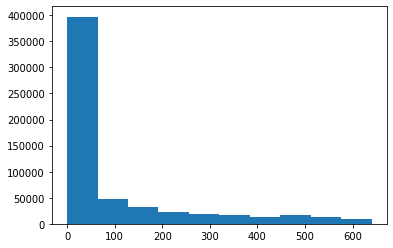

In [331]:
plt.hist(train['D1'])
plt.show()

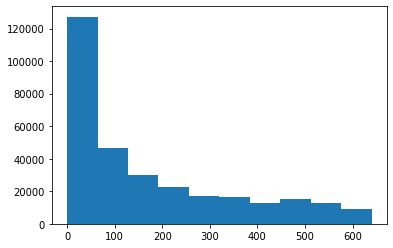

In [332]:
plt.hist(train['D2'])
plt.show()

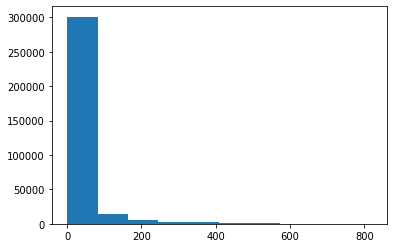

In [333]:
plt.hist(train['D3'])
plt.show()

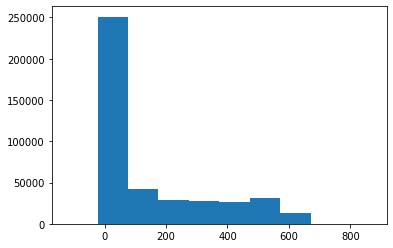

In [334]:
plt.hist(train['D4'])
plt.show()

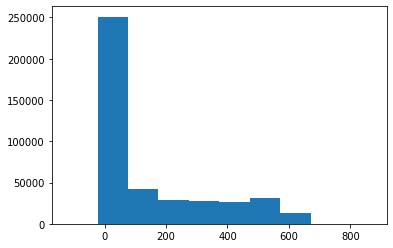

In [335]:
plt.hist(train['D4'])
plt.show()

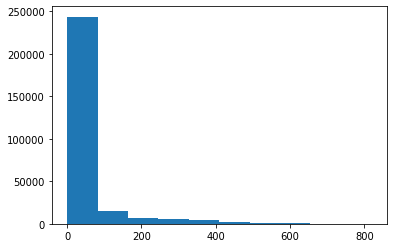

In [336]:
plt.hist(train['D5'])
plt.show()

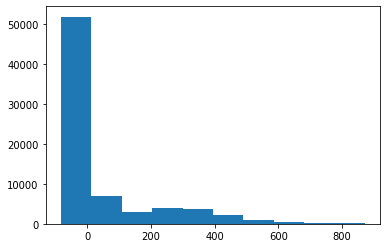

In [337]:
plt.hist(train['D6'])
plt.show()

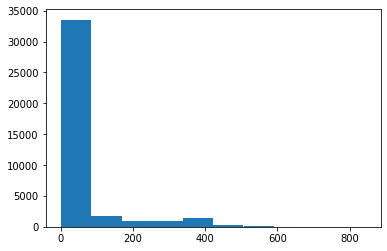

In [338]:
plt.hist(train['D7'])
plt.show()

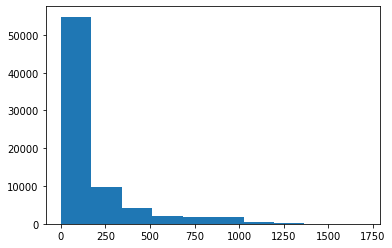

In [339]:
plt.hist(train['D8'])
plt.show()

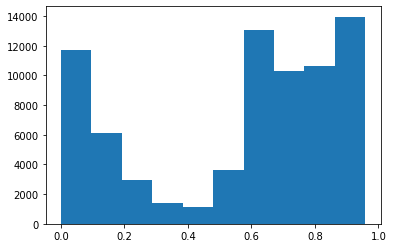

In [340]:
plt.hist(train['D9'])
plt.show()

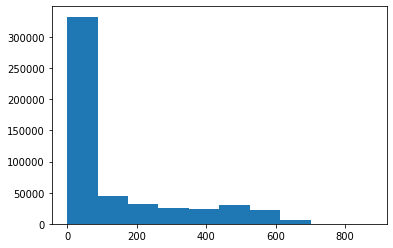

In [341]:
plt.hist(train['D10'])
plt.show()

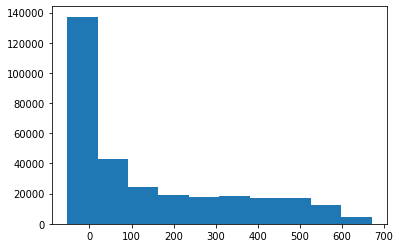

In [342]:
plt.hist(train['D11'])
plt.show()

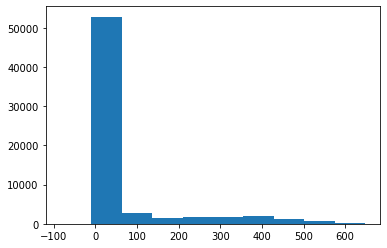

In [343]:
plt.hist(train['D12'])
plt.show()

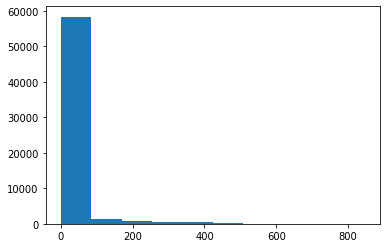

In [344]:
plt.hist(train['D13'])
plt.show()

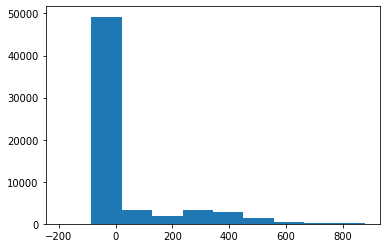

In [345]:
plt.hist(train['D14'])
plt.show()

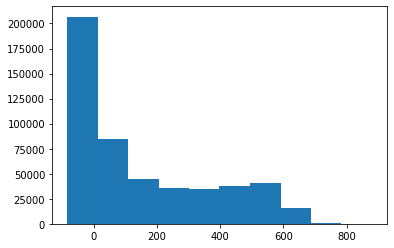

In [346]:
plt.hist(train['D15'])
plt.show()

In [347]:
train['M1'].value_counts(dropna=False, normalize=True)

T      0.540886307447421
NaN    0.459071358417719
F      0.000042334134860
Name: M1, dtype: float64

In [348]:
train['M2'].value_counts(dropna=False, normalize=True)

T      0.483401632404240
NaN    0.459071358417719
F      0.057527009178040
Name: M2, dtype: float64

In [349]:
train['M3'].value_counts(dropna=False, normalize=True)

NaN    0.459071358417719
T      0.426272564093880
F      0.114656077488400
Name: M3, dtype: float64

In [350]:
train['M4'].value_counts(dropna=False, normalize=True)

NaN    0.476587530057236
M0     0.332585430284147
M2     0.101373319334846
M1     0.089453720323771
Name: M4, dtype: float64

In [351]:
train['M5'].value_counts(dropna=False, normalize=True)

NaN    0.593494090154774
F      0.224355674467437
T      0.182150235377790
Name: M5, dtype: float64

In [352]:
train['M6'].value_counts(dropna=False, normalize=True)

F      0.385843465302943
T      0.327368171504047
NaN    0.286788363193010
Name: M6, dtype: float64

In [353]:
train['M7'].value_counts(dropna=False, normalize=True)

NaN    0.586353168286653
F      0.357933416872693
T      0.055713414840654
Name: M7, dtype: float64

In [354]:
train['M8'].value_counts(dropna=False, normalize=True)

NaN    0.586331154536526
F      0.262896670843635
T      0.150772174619839
Name: M8, dtype: float64

In [355]:
train['M9'].value_counts(dropna=False, normalize=True)

NaN    0.586331154536526
T      0.348250753547600
F      0.065418091915874
Name: M9, dtype: float64

In [356]:
train['V1'].value_counts(dropna=False, normalize=True)

1.0    0.527036271886748
NaN    0.472934940901548
0.0    0.000028787211705
Name: V1, dtype: float64

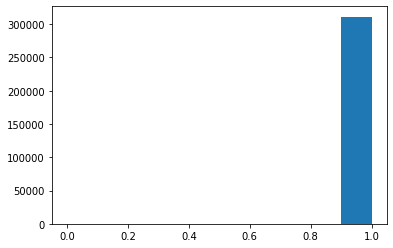

In [357]:
plt.hist(train['V1'])
plt.show()

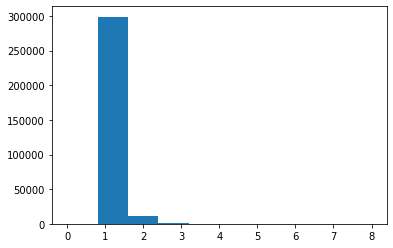

In [358]:
plt.hist(train['V2'])
plt.show()

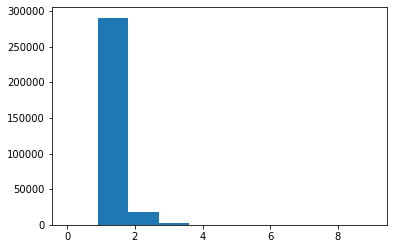

In [359]:
plt.hist(train['V3'])
plt.show()

In [360]:
train['V4'].value_counts(dropna=False, normalize=True)

NaN    0.472934940901548
1.0    0.417414569715853
0.0    0.095991804111491
2.0    0.012505503437532
3.0    0.000955058082433
4.0    0.000149016154706
5.0    0.000044027500254
6.0    0.000005080096183
Name: V4, dtype: float64

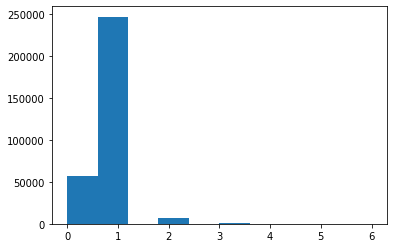

In [361]:
plt.hist(train['V4'])
plt.show()

In [362]:
train['V5'].value_counts(dropna=False, normalize=True)

NaN    0.472934940901548
1.0    0.411289667084363
0.0    0.091909100145629
2.0    0.021353337623192
3.0    0.002032038473262
4.0    0.000326819521116
5.0    0.000093135096691
6.0    0.000060961154198
Name: V5, dtype: float64

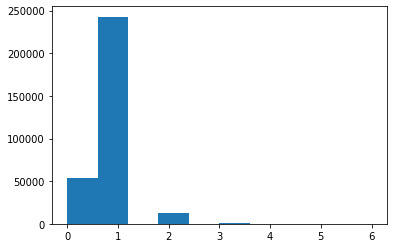

In [363]:
plt.hist(train['V5'])
plt.show()

In [364]:
train['V6'].value_counts(dropna=False, normalize=True)

1.0    0.505684627628950
NaN    0.472934940901548
2.0    0.019167202899042
3.0    0.001767873471738
4.0    0.000304805770989
5.0    0.000077894808142
0.0    0.000030480577099
6.0    0.000018627019338
7.0    0.000008466826972
8.0    0.000003386730789
9.0    0.000001693365394
Name: V6, dtype: float64

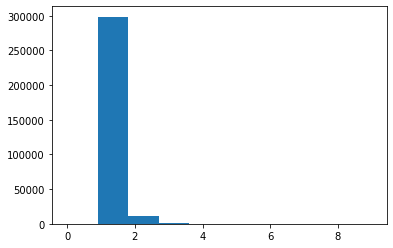

In [365]:
plt.hist(train['V6'])
plt.show()

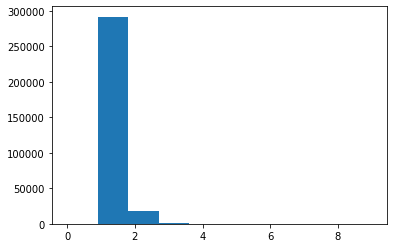

In [366]:
plt.hist(train['V7'])
plt.show()

In [367]:
for col in train.columns:
    print(col)

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167

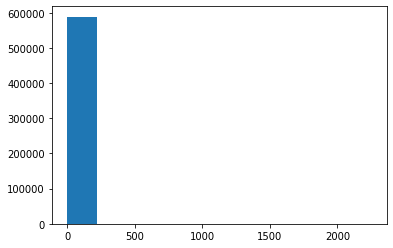

In [368]:
plt.hist(train['C4'])
plt.show()

# Feature Engineering

In [369]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_30 OS
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)

In [370]:
train['id_30'].value_counts()

NAN        512975
Windows     36739
iOS         19782
Mac         13580
Android      6303
Linux        1136
other          15
func           10
Name: id_30, dtype: int64

In [371]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_31 Browser
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

In [208]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    

In [214]:
# Label Encoding
for f in train.drop('isFraud', axis=1).columns:
    if train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values))
        train[f] = lbl.transform(list(train[f].values))

In [225]:
train.drop('TransactionDT', axis=1)
train.drop('_ymd', axis=1)
train.drop('_year_month', axis=1)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,_seq_week,Date,_year_month,_weekday,_hour,_day,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,2987000,0,86400,68.500000,4,13926,NaN,150.0,1,142.0,...,0,2017-12-01 00:00:00,0,4,0,1,6,6,6,6
1,2987001,0,86401,29.000000,4,2755,404.0,150.0,2,102.0,...,0,2017-12-01 00:00:01,0,4,0,1,4,0,6,6
2,2987002,0,86469,59.000000,4,4663,490.0,150.0,4,166.0,...,0,2017-12-01 00:01:09,0,4,0,1,5,0,6,6
3,2987003,0,86499,50.000000,4,18132,567.0,150.0,2,117.0,...,0,2017-12-01 00:01:39,0,4,0,1,9,0,6,6
4,2987004,0,86506,50.000000,1,4497,514.0,150.0,2,102.0,...,0,2017-12-01 00:01:46,0,4,0,1,4,0,6,6
5,2987005,0,86510,49.000000,4,5937,555.0,150.0,4,226.0,...,0,2017-12-01 00:01:50,0,4,0,1,4,0,6,6
6,2987006,0,86522,159.000000,4,12308,360.0,150.0,4,166.0,...,0,2017-12-01 00:02:02,0,4,0,1,9,0,6,6
7,2987007,0,86529,422.500000,4,12695,490.0,150.0,4,226.0,...,0,2017-12-01 00:02:09,0,4,0,1,7,0,6,6
8,2987008,0,86535,15.000000,1,2803,100.0,150.0,4,226.0,...,0,2017-12-01 00:02:15,0,4,0,1,7,0,6,6
9,2987009,0,86536,117.000000,4,17399,111.0,150.0,2,224.0,...,0,2017-12-01 00:02:16,0,4,0,1,9,0,6,6


In [227]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [ ]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [216]:
# iterating the columns 
for col in train.columns: 
    print(col)

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167